# Effect of inducing point locations in sparse Gaussian processes

In this notebook, we will show the impact of optimizing the locations of the inducing points in a sparse Gaussian process. To this end, we compare the posterior distribution of the predictions from the exact GP with the posterior distribution of the predictions from the sparse GP with fixed inducing points and the posterior distribution of the predictions from the sparse GP with optimized inducing points. We will be using `gpflow` for the implementation of the Gaussian processes.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gpflow

plt.rcParams.update({
    'figure.dpi': 150,
    'text.usetex': True, # comment this if tex is not installed in the system
})
plt.style.use('ggplot')

## Data

We will use the 1D example from Snelson and Ghahramani (2006). There are a total of 200 observations.

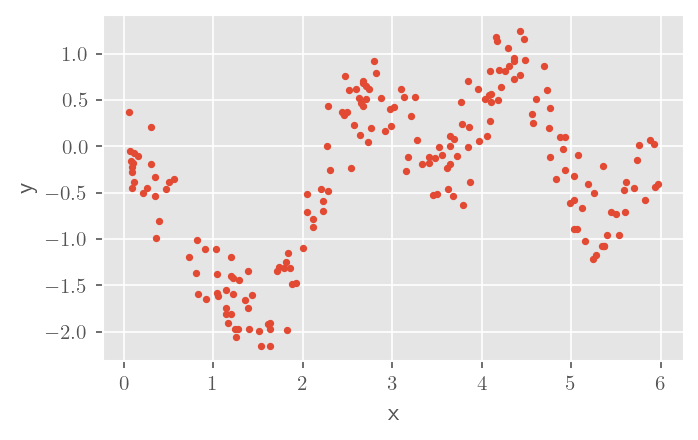

In [2]:
# read in the data
X = np.loadtxt('snelson_data/snelson_train_inputs.dat').reshape(-1, 1)
y = np.loadtxt('snelson_data/snelson_train_outputs.dat').reshape(-1, 1)

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
_ = ax.plot(X, y, '.', markersize=5)
_ = ax.set_xlabel('x')
_ = ax.set_ylabel('y')

In [3]:
X_test = np.linspace(-0, 6, 100).reshape(-1, 1)

## Plotting utilities for all models

In [4]:
def plot_predictions(model, X_test, ax):
    '''Plot the mean and 95% confidence interval for the predictions 
    of the model on the test data `X_test`
    '''
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(5, 3))
    
    y_mean, y_var = model.predict_y(X_test)
    _ = ax.plot(X_test.ravel(), y_mean.numpy().ravel(), color='steelblue')
    _ = ax.fill_between(
        X_test.ravel(),
        y_mean.numpy().ravel() - 1.96 * np.sqrt(y_var.numpy().ravel()),
        y_mean.numpy().ravel() + 1.96 * np.sqrt(y_var.numpy().ravel()),
        color='steelblue', alpha=0.5
    )
    return ax

def generate_figure(model, X_test, figsize):
    '''
    Generate a figure showin the training data, and the predicted mean
    and 95% confidence interval of the model on the test data `X_test`.
    '''
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    _ = ax.plot(X, y, 'k.', markersize=2)
    _ = plot_predictions(model, X_test, ax)
    
    # label axes
    _ = ax.set_xlabel(r'$x$')
    _ = ax.set_ylabel(r'$y$')

    # remove tick labels
    _ = ax.set_yticklabels([])
    _ = ax.set_xticklabels([])

    return fig, ax

## Exact GP model

In [5]:
def get_kernel():
    return gpflow.kernels.SquaredExponential()

In [6]:
# Run exact inference on training 
exact_model = gpflow.models.GPR(data=(X, y), kernel=get_kernel())
opt = gpflow.optimizers.Scipy()
opt.minimize(
    exact_model.training_loss, 
    exact_model.trainable_variables,
    method='L-BFGS-B',
    #options=dict(maxiter=100)
)
gpflow.utilities.print_summary(exact_model)

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │     value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.769165  │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.612343  │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 0.0796472 │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧════════════

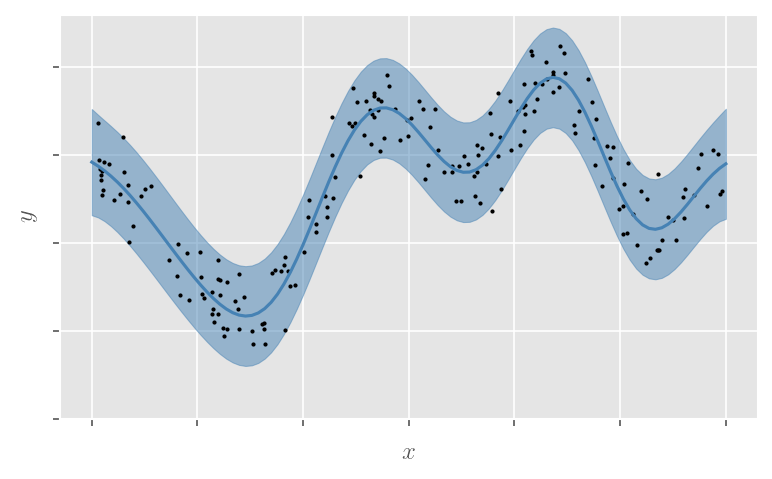

In [7]:
fig, ax = generate_figure(exact_model, X_test, figsize=(6, 3.5))
_ = ax.set_ylim([-3, 1.6])
fig.savefig('exact_vs_sparse_figs/exact_gp_predictions.png', bbox_inches='tight')
fig.savefig('exact_vs_sparse_figs/exact_gp_predictions.pdf', bbox_inches='tight')

In [8]:
# figure with title
_ = ax.set_title('Exact GP')
fig.savefig('figs_w_title/svi_exact_gp_predictions.pdf', bbox_inches='tight')

## Sparse GP with fixed inducing points

In [9]:
def initialize_from_exact(sparse_model):
    '''
    Utility function to initialize the hyperparameters from the exact model
    '''
    sparse_model.likelihood.variance.assign(exact_model.likelihood.variance)
    sparse_model.kernel.variance.assign(exact_model.kernel.variance)
    sparse_model.kernel.lengthscales.assign(exact_model.kernel.lengthscales)

In [11]:
# Sparse GP model with 6 inducing points chosen uniformly in the input space
# The inducing points are not trainable.
sgp_model1 = gpflow.models.SGPR(
    data=(X, y),
    kernel=get_kernel(),
    inducing_variable=np.linspace(0, 6, 6).reshape(-1, 1)    
)
gpflow.set_trainable(sgp_model1.inducing_variable, False)
initialize_from_exact(sgp_model1)

sgp_opt1 = gpflow.optimizers.Scipy()
sgp_opt1.minimize(
    sgp_model1.training_loss, 
    sgp_model1.trainable_variables,
    method='L-BFGS-B',
    #options=dict(maxiter=100)
)

gpflow.utilities.print_summary(sgp_model1)



╒══════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════════════╕
│ name                     │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value               │
╞══════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════════════╡
│ SGPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.3394352595728643  │
├──────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────────────┤
│ SGPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.8906300674691258  │
├──────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────────────┤
│ SGPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 0.206066152269

In the cell below, we can see the posterior distribution of the predictions from the sparse GP with fixed inducing points. Clearly, the model is not able to replicate the exact GP posterior distribution.

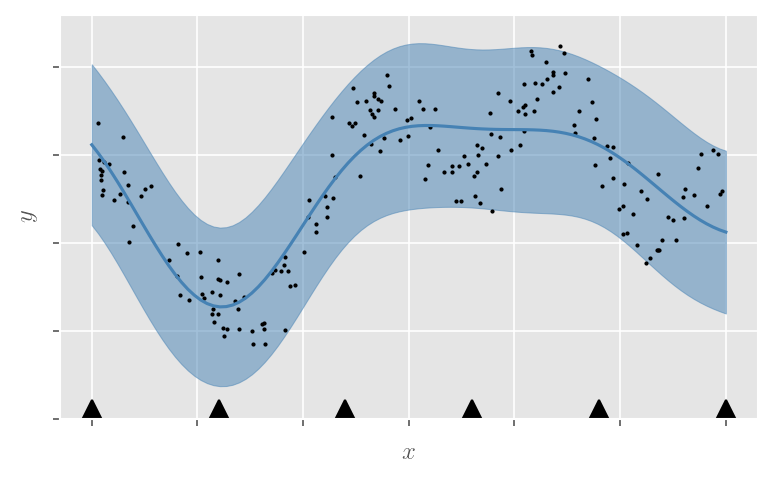

In [12]:
fig, ax = generate_figure(sgp_model1, X_test, figsize=(6, 3.5))
_ = ax.set_ylim([-3, 1.6])
_ = ax.plot(sgp_model1.inducing_variable.Z.numpy(),
    -2.9 * np.ones(6), 'k^', markersize=10
)
fig.savefig('exact_vs_sparse_figs/sparse_gp_predictions_without_opt.png', bbox_inches='tight')
fig.savefig('exact_vs_sparse_figs/sparse_gp_predictions_without_opt.pdf', bbox_inches='tight')

## Sparse GP with inducing points optimized

In [13]:
sgp_model2 = gpflow.models.SGPR(
    data=(X, y),
    kernel=get_kernel(),
    inducing_variable=np.linspace(0, 6, 6).reshape(-1, 1)    
)
initialize_from_exact(sgp_model2)

sgp_opt2 = gpflow.optimizers.Scipy()
sgp_opt1.minimize(
    sgp_model2.training_loss, 
    sgp_model2.trainable_variables,
    method='L-BFGS-B',
    #options=dict(maxiter=100)
)

gpflow.utilities.print_summary(sgp_model2)



╒══════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════════════╕
│ name                     │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value               │
╞══════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════════════╡
│ SGPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.148953662372652   │
├──────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────────────┤
│ SGPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.5893340823501987  │
├──────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────────────┤
│ SGPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 0.105914041296

In the cell below, we can see that the posterior distribution of the predictions from the sparse GP with optimized inducing points is very close to the exact GP posterior distribution with just 6 inducing points.

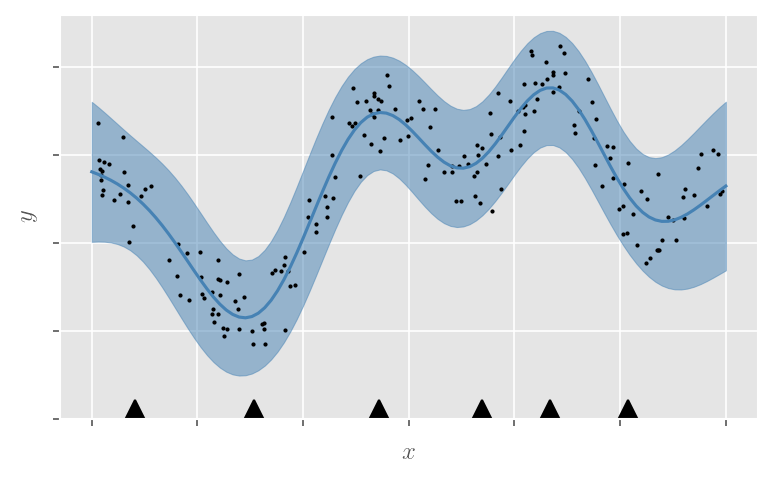

In [14]:
fig, ax = generate_figure(sgp_model2, X_test, figsize=(6, 3.5))
_ = ax.set_ylim([-3, 1.6])
_ = ax.plot(sgp_model2.inducing_variable.Z.numpy(),
    -2.9 * np.ones(6), 'k^', markersize=10
)
fig.savefig('exact_vs_sparse_figs/sparse_gp_predictions.png', bbox_inches='tight')
fig.savefig('exact_vs_sparse_figs/sparse_gp_predictions.pdf', bbox_inches='tight')

In [15]:
# save figure with title
_ = ax.set_title('Variational GP with 6 inducing points')
fig.savefig('figs_w_title/svi_var_gp_predictions.pdf', bbox_inches='tight')

In [16]:
sgp_model3 = gpflow.models.SGPR(
    data=(X, y),
    kernel=get_kernel(),
    inducing_variable=np.linspace(0, 6, 8).reshape(-1, 1)    
)
initialize_from_exact(sgp_model3)

sgp_opt3 = gpflow.optimizers.Scipy()
sgp_opt3.minimize(
    sgp_model3.training_loss, 
    sgp_model3.trainable_variables,
    method='L-BFGS-B',
    #options=dict(maxiter=100)
)

gpflow.utilities.print_summary(sgp_model3)

╒══════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════════════╕
│ name                     │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value               │
╞══════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════════════╡
│ SGPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.616756170070343   │
├──────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────────────┤
│ SGPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.7191852883504213  │
├──────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────────────┤
│ SGPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 0.085916571205

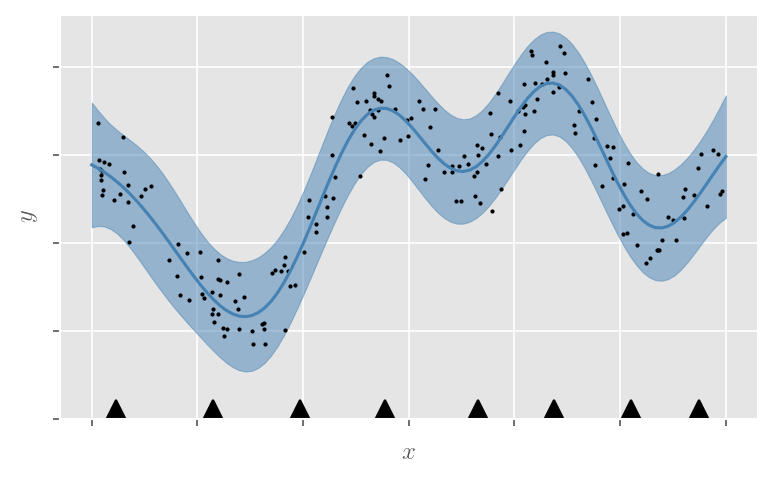

In [20]:
fig, ax = generate_figure(sgp_model3, X_test, figsize=(6, 3.5))
_ = ax.set_ylim([-3, 1.6])
_ = ax.plot(sgp_model3.inducing_variable.Z.numpy(),
    -2.9 * np.ones(8), 'k^', markersize=10
)
fig.savefig('exact_vs_sparse_figs/sparse_gp_predictions_8_pts.png', bbox_inches='tight')
fig.savefig('exact_vs_sparse_figs/sparse_gp_predictions_8_pts.pdf', bbox_inches='tight')